Pyomo example code for model predictive control based on Jeffrey C. Kantor's sample code.
Source: https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/02.06-Model-Predictive-Control-of-a-Double-Integrator.html

In [60]:
import pyomo.environ as pyo
import numpy as np



def mpc(pos_init=0.5, pos_target=0.7, vel_init=0.5, vel_target=0, N=30, h=0.1):
    m = pyo.ConcreteModel()
    m.states = pyo.RangeSet(1, 2)
    m.k = pyo.RangeSet(0, N)

    m.h = pyo.Param(initialize=h, mutable=True)
    m.ic = pyo.Param(m.states, initialize={1: pos_init, 2: vel_init}, mutable=True)  # Initial condition
    m.gamma = pyo.Param(default=0.5, mutable=True)

    m.x = pyo.Var(m.states, m.k)
    m.icfix = pyo.Constraint(m.states, rule=lambda m, i: m.x[i, 0] == m.ic[i])  # Initialize the variable.
    m.x[1,N].fix(pos_target)  # position at time N should be 0
    m.x[2,N].fix(vel_target)  # velocity at time N should be 0

    m.u = pyo.Var(m.k, bounds=(-1, 1))
    m.upos = pyo.Var(m.k, bounds=(0, 1))
    m.uneg = pyo.Var(m.k, bounds=(0, 1))
    m.usum = pyo.Constraint(m.k, rule=lambda m, k: m.u[k] == m.upos[k] - m.uneg[k])

    m.y = pyo.Var(m.k, bounds=(-1, 1))
    m.ypos = pyo.Var(m.k, bounds=(0, 1))
    m.yneg = pyo.Var(m.k, bounds=(0, 1))
    m.ysum = pyo.Constraint(m.k, rule=lambda m, k: m.y[k] == m.ypos[k] - m.yneg[k])

    m.x1_update = pyo.Constraint(m.k, rule=lambda m, k:
                                 m.x[1, k+1] == m.x[1, k] + m.h*m.x[2, k] + (m.h**2 / 2) * m.u[k] if k < N else pyo.Constraint.Skip)
    m.x2_update = pyo.Constraint(m.k, rule=lambda m, k:
                                 m.x[2, k+1] == m.x[2, k] + m.h*m.u[k] if k < N else pyo.Constraint.Skip)

    m.y_output = pyo.Constraint(m.k, rule=lambda m, k: m.y[k] == m.x[1, k])

    m.uobj = m.gamma * sum(m.upos[k] + m.uneg[k] for k in m.k)
    m.yobj = (1-m.gamma) * sum(m.ypos[k] + m.yneg[k] for k in m.k)
    m.obj = pyo.Objective(expr=m.uobj + m.yobj, sense=pyo.minimize)
    return m

m = mpc(0.5, 0., 0., 0)

result = pyo.SolverFactory('cbc').solve(m)

In [61]:
m.x.display()

x : Size=62, Index=x_index
    Key     : Lower : Value          : Upper : Fixed : Stale : Domain
     (1, 0) :  None :            0.5 :  None : False : False :  Reals
     (1, 1) :  None :          0.495 :  None : False : False :  Reals
     (1, 2) :  None :           0.48 :  None : False : False :  Reals
     (1, 3) :  None :     0.45842105 :  None : False : False :  Reals
     (1, 4) :  None :     0.43526316 :  None : False : False :  Reals
     (1, 5) :  None :     0.41210526 :  None : False : False :  Reals
     (1, 6) :  None :     0.38894737 :  None : False : False :  Reals
     (1, 7) :  None :     0.36578947 :  None : False : False :  Reals
     (1, 8) :  None :     0.34263158 :  None : False : False :  Reals
     (1, 9) :  None :     0.31947368 :  None : False : False :  Reals
    (1, 10) :  None :     0.29631579 :  None : False : False :  Reals
    (1, 11) :  None :     0.27315789 :  None : False : False :  Reals
    (1, 12) :  None :           0.25 :  None : False : False : 

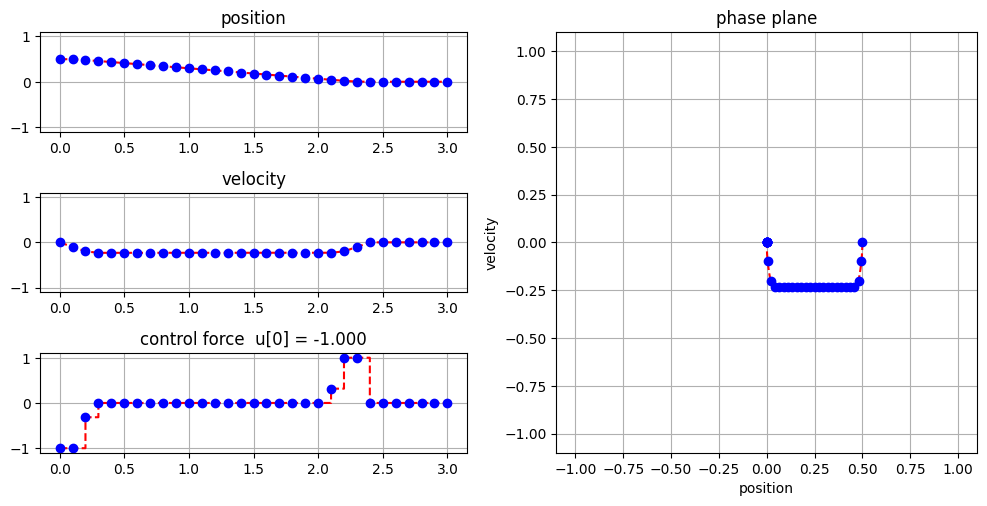

In [62]:
from itertools import chain
import matplotlib.pyplot as plt
def plot_results(m):
    results = pyo.SolverFactory('cbc').solve(m)
    if str(results.solver.termination_condition) != "optimal":
        print(results.solver.termination_condition)
        return

    # solution data at sample times
    h = m.h()
    K = np.array([k for k in m.k])
    u = [m.u[k]() for k in K]
    y = [m.y[k]() for k in K]
    v = [m.x[2,k]() for k in K]

    # interpolate between sample times
    t = np.linspace(0, h)
    tp = [_ for _ in chain.from_iterable(k*h + t for k in K[:-1])]
    up = [_ for _ in chain.from_iterable(u[k] + t*0 for k in K[:-1])]
    yp = [_ for _ in chain.from_iterable(y[k] + t*(v[k] + t*u[k]/2) for k in K[:-1])]
    vp = [_ for _ in chain.from_iterable(v[k] + t*u[k] for k in K[:-1])]

    fig = plt.figure(figsize=(10,5))

    ax1 = fig.add_subplot(3, 2, 1)
    ax1.plot(tp, yp, 'r--', h*K, y, 'bo')
    ax1.set_title('position')

    ax2 = fig.add_subplot(3, 2, 3)
    ax2.plot(tp, vp, 'r--', h*K, v, 'bo')
    ax2.set_title('velocity')

    ax3 = fig.add_subplot(3, 2, 5)
    ax3.plot(np.append(tp, K[-1]*h), np.append(up, u[-1]), 'r--', h*K, u, 'bo')
    ax3.set_title('control force  u[0] = {0:<6.3f}'.format(u[0]))

    ax4 = fig.add_subplot(1, 2, 2)
    ax4.plot(yp, vp, 'r--', y, v, 'bo')
    ax4.set_xlim([-1.1, 1.1])
    ax4.set_aspect('equal', 'box')
    ax4.set_title('phase plane')
    ax4.set_xlabel('position')
    ax4.set_ylabel('velocity')

    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_ylim(-1.1, 1.1)
        ax.grid(True)
    fig.tight_layout()

plot_results(m)
